## Import mitsuba libraries 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import enoki as ek
import mitsuba
mitsuba.set_variant('gpu_autodiff_rgb')
%load_ext autoreload
%autoreload 2

2022-04-16 10:50:00 INFO main [optix_api.cpp:56] Dynamic loading of the Optix library ..

In [2]:
!nvidia-smi

Sat Apr 16 10:50:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 27%   35C    P2    48W / 250W |    173MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:67:00.0 Off |                  N/A |
| 27%   

In [3]:

import multiprocessing
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
from mitsuba.render import  Emitter
from mitsuba.render import  Scene
import multiprocessing
from mitsuba.core import Thread, Vector3f,Float
from mitsuba.core.xml import load_file
from mitsuba.python.util import traverse
from mitsuba.python.autodiff import render_torch, write_bitmap, render

from mitsuba.core import Bitmap, Struct, Thread
from mitsuba.core.xml import load_file


## Load a scene form a .xml file

In [4]:
import xml.etree.ElementTree as ET

# Get a reference to the thread's file resolver
fileResolver = Thread.thread().file_resolver()

# Register any searchs path needed to load scene resources (optional)

fileResolver.append('/home/tianfuwang/mitsuba_structured_light_renderer/mistuba_examples/scenes')


## Render a loaded scene

In [5]:
from MSLR.mitsuba2_renderer import * 
from MSLR.greycode import *
from MSLR.camera import * 
from MSLR.ray_trace import *
from MSLR.screen import * 
from MSLR.plot import *
from MSLR.sinusoid import *

In [6]:
#set the logger print level to Error for less verbose printout message
print(Thread.thread().logger().log_level() )
Thread.thread().logger().set_log_level( mitsuba.core.LogLevel.Error)
print(Thread.thread().logger().log_level() )


LogLevel.Info
LogLevel.Error


## Render the ground truth depth map


In [7]:

#special scene for captuing depth values 

scene_path ="/home/tianfuwang/mitsuba_structured_light_renderer/mistuba_examples/scenes/Struc_light_depth.xml"


#load scene from file path 

scene = load_scene_file(scene_path)

renderer = mitsuba_renderer()
renderer.scene = scene

#render the scene 

renderer.render()

#convert the rendered image to a np array

film = renderer.scene.sensors()[0].film()
bmp = film.bitmap(raw=True)
bmp_linear_rgb = bmp.convert(Bitmap.PixelFormat.MultiChannel, Struct.Type.Float32, srgb_gamma=False)
image_np = np.array(bmp_linear_rgb)

depth = image_np[:,:,-3 : ] / image_np[:,:, -4: -3]

    



In [8]:
print(depth.min())

-0.9906573


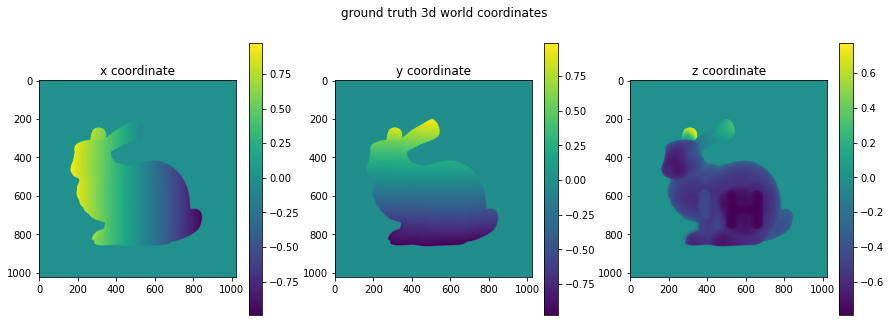

In [9]:
coordinates = ["x", "y", "z"]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ground truth 3d world coordinates')

for i in range(3):
    img = ax[i %3].imshow(depth[:,:,i])
    ax[i %3].set_title( coordinates[i] + ' coordinate' ) 
    plt.colorbar(img,ax=ax[i %3])

## Generate Sinusoid Patterns

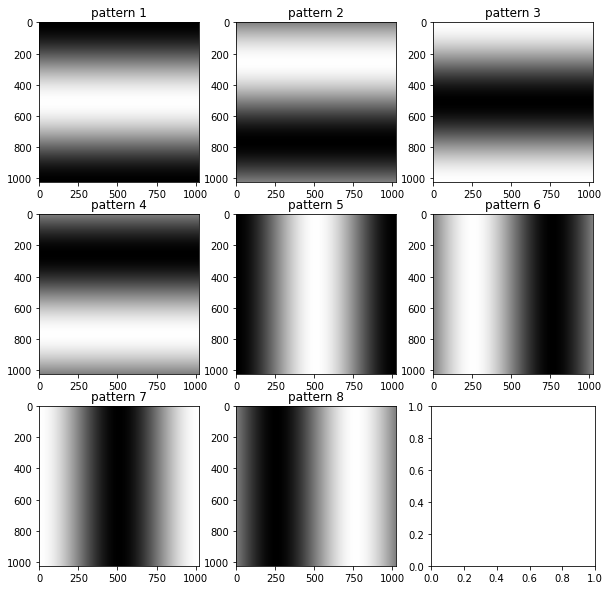

In [10]:
sin = sinusoid(dim = 1024)
pattern_num = 8
patterns = sin.generate_pattern() 


fig, ax = plt.subplots(3,3, figsize = (10,10))
for i in range(pattern_num):
#     matplotlib.image.imsave('/home/tianfuwang/mitsuba_structured_light_renderer/mistuba_examples/scenes/textures/' + str(i + 1) + '.png', patterns[i])
    ax[i//3, i %3].imshow(patterns[i])
    ax[i//3, i %3].set_title('pattern ' + str(i + 1) ) 

## Render the images 

In [11]:
scene_path ="/home/tianfuwang/mitsuba_structured_light_renderer/mistuba_examples/scenes/Struc_light.xml"
#set the dimensions for the rendered image
render_dim = 1024
#locate the param name that points to the projector pattern 
pattern_param = "projector.irradiance"

renderer = mitsuba_renderer()

renderer.load_scene(scene_path)

#render the images with patterns given in the pattern array, along with pure white and black patterns
renders, white, black = renderer.render_scene_with_patterns(pattern_param, patterns,render_dim, sRGB= False)


        

## Visualize Rendered Images


In [ ]:
fig, ax = plt.subplots(3,3, figsize = (20,20))
for i in range(pattern_num):
    ax[i//3, i %3].imshow((renders[i]))
    ax[i//3, i %3].set_title('render of pattern ' + str(i + 1) ) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


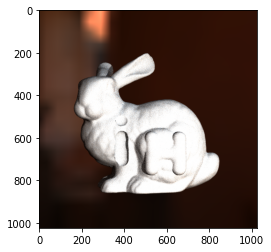

In [13]:
plt.imshow(white)
plt.show()